In [51]:
%matplotlib inline
import pylab as plt
import numpy as np
from astrometry.util.fits import *
from astrometry.util.util import Tan,Sip
from glob import glob
import fitsio
import sys
import os
import matplotlib
import tractor
from tractor.constrained_optimizer import *
matplotlib.rcParams['figure.figsize'] = 10,8
from scipy.ndimage.filters import gaussian_filter

In [9]:
# GFA Metrology results -- GFA#10
# https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=4832
# Images --
# https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=4832;filename=GFA%2310_GIF-Metrology-images.zip;version=2    

In [293]:
def blanton_noise(img):
    # Estimate per-pixel noise via Blanton's 5-pixel MAD
    slice1 = (slice(0,-5,10),slice(0,-5,10))
    slice2 = (slice(5,None,10),slice(5,None,10))
    mad = np.median(np.abs(img[slice1] - img[slice2]).ravel())
    sig1 = 1.4826 * mad / np.sqrt(2.)
    return sig1

def measure_gfa_spots(imgdir, ss_text, plots=True, chatty=True):
    rows = [row for row in ss_text.split('\n') if len(row.strip())>0]
    words = [row.strip().split('\t') for row in rows]
    del rows
        
    def chat(*X):
        if chatty:
            print(*X)

    G = fits_table()

    keeprows = []
    bgfn = None
    for row in words:
        if 'Background' in row[1]:
            if bgfn is None:
                bgfn = row[0]
        else:
            keeprows.append(row)
    words = keeprows

    G.img_fn = np.array([w[2] for w in words])
    G.mmx = np.array([float(w[0]) for w in words]).astype(np.float32)
    G.mmy = np.array([float(w[1]) for w in words]).astype(np.float32)
    G.orig_ssx = np.array([float(w[5]) for w in words]).astype(np.int16)
    G.orig_ssy = np.array([float(w[6]) for w in words]).astype(np.int16)

    G.measx = np.zeros(len(G), np.float32)
    G.measy = np.zeros(len(G), np.float32)
    G.prescan = np.zeros(len(G), np.uint8)
    G.overscan = np.zeros(len(G), np.uint8)
    G.quadrant = np.zeros(len(G), np.uint8)

    if bgfn is None:
        # Use median of images?!
        print('Estimating "background" image from median of observations')
        bgimgs = []
        for i in range(1,5):
            stack = []
            for fn in G.img_fn:
                pth = os.path.join(imgdir, fn)
                if not os.path.exists(pth):
                    print('Image', fn, 'does not exist!')
                    continue
                img = fitsio.read(pth, ext=i)
                stack.append(img)
            stack = np.dstack(stack)
            bgimgs.append(np.median(stack, axis=2))
    else:
        bg = os.path.join(imgdir, bgfn)
        Fbg = fitsio.FITS(bg)
        bgimgs = [Fbg[i].read() for i in range(1,5)]
    ima = dict(interpolation='nearest', origin='lower')
    
    all_coords = []

    for iimg,imgfn in enumerate(G.img_fn):
        chat()
        chat('Image', imgfn)
        fn = os.path.join(imgdir, imgfn) #'IMG_%i.fits' % imgnum)
        if not os.path.exists(fn):
            # Try .fit -> .fits
            if os.path.exists(fn + 's'):
                fn += 's'
            else:
                print('Image', imgfn, 'does not exist!')
                continue
        F = fitsio.FITS(fn)
        hdr = F[0].read_header()
        prescan = hdr['PRESCAN']
        overscan = hdr['OVERSCAN']
        #print('Prescan', prescan, 'overscan', overscan)
        bestsn = 0.
        for q in range(4):
            img = F[q+1].read()
            hi,wi = img.shape
            active = (img - bgimgs[q])[:, prescan:-overscan]
            #print('Active area:', active.shape)

            active = active - np.median(active)
            ah,aw = active.shape
            sig1 = blanton_noise(active)

            # Mask 8 bad rows at the bottom
            active[:8,:] = 0.
            
            smoo = gaussian_filter(active, 2.)
            noise = blanton_noise(smoo)
            maxsn = np.max(smoo/noise)
            chat('S/N', maxsn)
            imax = np.argmax(smoo/noise)
            i,j = np.unravel_index(imax, smoo.shape)

            if plots:
                plt.clf()
                plt.imshow(active, vmin=-3.*sig1, vmax=20.*sig1, **ima)
                ax = plt.axis()
                plt.plot(j, i, 'o', mec='r', ms=20, mfc='none')
                plt.show()
            
            if maxsn < 2000:
                continue
            if maxsn < bestsn:
                continue
            chat('At', j,i)
            if i<10 or j<10:
                chat('Too close to edge')
                continue
            bestsn = maxsn
            cutout = active[i-10:i+11, j-10:j+11]

            SAT = 25000
        
            satur = (cutout > SAT)
            inverr = np.ones_like(cutout) / sig1
            inverr[satur] = 0.
        
            tim = tractor.Image(data=cutout, inverr=inverr,
                               psf=tractor.NCircularGaussianPSF([2.], [1.]))
            src = tractor.PointSource(tractor.PixPos(10, 10), tractor.Flux(np.sum(cutout)))
            tr = tractor.Tractor([tim], [src], optimizer=ConstrainedOptimizer())
            tr.freezeParam('images')
            tr.optimize_loop()
            #tr.printThawedParams()
            tr.thawParam('images')
            tim.freezeAllBut('psf')
            tim.psf.freezeParam('weights')
            tr.optimize_loop()
            #tr.printThawedParams()
            ox = src.pos.x + j - 10
            oy = src.pos.y + i - 10
            chat('Optimized position: (%.1f, %.1f)' % (ox, oy))

            G.measx[iimg] = ox
            G.measy[iimg] = oy
            G.prescan[iimg] = prescan
            G.overscan[iimg] = overscan
            G.quadrant[iimg] = q+1
            
            #plt.imshow(active, **ima)
            #plt.show()
            if plots:
                plt.clf()
                plt.subplot(2,2,1)
                mod = tr.getModelImage(0)
                mx = max(max(np.minimum(mod, SAT).ravel()), max(cutout.ravel()))
                cima = ima.copy()
                cima.update(vmin=cutout.min(), vmax=mx)
                plt.imshow(cutout, **cima)
                plt.xticks([]); plt.yticks([])
                plt.subplot(2,2,2)
                plt.imshow(mod, **cima)
                plt.xticks([]); plt.yticks([])
                plt.subplot(2,2,3)
                plt.imshow(tr.getChiImage(0), **ima)
                plt.xticks([]); plt.yticks([])
                plt.subplot(2,2,4)
                plt.plot(cutout[:,10], color='b', alpha=0.5, lw=5)
                plt.plot(cutout[10,:], color='g', alpha=0.5, lw=5)
                plt.plot(mod[:,10], color='b')
                plt.plot(mod[10,:], color='g')
                plt.show()

    G.ssx = np.zeros(len(G), np.float32)
    G.ssy = np.zeros(len(G), np.float32)

    I = np.array([q in [1,4] for q in G.quadrant])
    G.ssx[I] = G.measx[I] + G.prescan[I]
    I = np.array([q in [2,3] for q in G.quadrant])
    G.ssx[I] = 2048 - G.measx[I] + G.prescan[I] + 2 * G.overscan[I]

    I = np.array([q in [1,2] for q in G.quadrant])
    G.ssy[I] = 1056*2 - G.measy[I]
    I = np.array([q in [3,4] for q in G.quadrant])
    G.ssy[I] = G.measy[I]

    G.mtnx = np.zeros(len(G), np.float32)
    G.mtny = np.zeros(len(G), np.float32)

    I = np.array([q in [1,4] for q in G.quadrant])
    G.mtnx[I] = G.measx[I]
    I = np.array([q in [2,3] for q in G.quadrant])
    G.mtnx[I] = 2047 - G.measx[I]

    I = np.array([q in [1,2] for q in G.quadrant])
    G.mtny[I] = 2063 - G.measy[I]
    I = np.array([q in [3,4] for q in G.quadrant])
    G.mtny[I] = G.measy[I]

    # The above 'livey' is in the range [0, 2063], ie the real CCD area, but on the mountain,
    # there is a mask for the frame transfer; exposed area is half that, 1032.
    G.mtny -= 1032/2

    # Switch to FITS pixel indexing here --
    G.mtnx += 1.0
    G.mtny += 1.0
    
    Igood = np.flatnonzero(G.quadrant > 0)
    N = len(Igood)
    A = np.zeros((N,3))
    A[:,0] = 1.
    A[:,1] = G.mmx[Igood]
    A[:,2] = G.mmy[Igood]
    r = np.linalg.lstsq(A, G.mtnx[Igood], rcond=None)
    cx = r[0]
    r = np.linalg.lstsq(A, G.mtny[Igood], rcond=None)
    cy = r[0]

    G.fitx = (cx[0] + G.mmx*cx[1] + G.mmy*cx[2]).astype(np.float32)
    G.fity = (cy[0] + G.mmx*cy[1] + G.mmy*cy[2]).astype(np.float32)

    print('Scatter from spreadsheet to measured pixel positions: %.1f pixels' %
          np.mean(np.hypot(G.orig_ssx[Igood] - G.ssx[Igood], G.orig_ssy[Igood] - G.ssy[Igood])))
    print('Scatter from measured to fit positions: %.1f pixels' %
          np.mean(np.hypot(G.mtnx[Igood] - G.fitx[Igood], G.mtny[Igood] - G.fity[Igood])))
    nbad = np.sum(G.quadrant == 0)
    if nbad:
        print('Failed to measure a spot in', nbad, 'images:', G.img_fn[G.quadrant == 0])
    return G, cx, cy

In [294]:
spreadsheet_8 = '''		IMG_22.fits	Background reference			
38.5	58	IMG_23.fits	Quadrant 3top right	50.1	2113	548
50	58	IMG_24.fits	Quadrant 3top left	49.7	1348	545
56.5	58	IMG_26.fits	Quadrant 4 upper right	49.7	850	544
67.5	58	IMG_27.fits	Quadrant 4 upper left	49.6	117	541
45.5	63	IMG_28.fits	Quadrant 3 lower middle	50.5	1646	880
60.75	63	IMG_29.fits	Quadrant 4 lower middle	49.9	566	876
60.75	67	IMG_30.fits	Quadrant 1 upper middle	50.1	565	1191
45.5	67	IMG_31.fits	Quadrant 2 Upper Middle	50.2	1645	1194
38.5	71	IMG_32.fits	Quadrant 2 lower right	49.9	2111	1463
50	71	IMG_33.fits	Quadrant 2 lower left	50.2	1345	1460
56.5	71	IMG_34.fits	Quadrant 1 lower right	50.3	848	1459
67.5	71	IMG_35.fits	Quadrant 1 lower left	49.9	115	1455'''
G8,tx8,ty8 = measure_gfa_spots('gfa-metrology-images/8', spreadsheet_8, plots=False, chatty=False)

Scatter from spreadsheet to measured pixel positions: 1.0 pixels
Scatter from measured to fit positions: 0.2 pixels


In [295]:
spreadsheet_10 = '''		IMG_40.fits	Background reference	47.4		
38.5	58	IMG_41.fits	Quadrant 3top right	47.6	2112	537
50	58	IMG_42.fits	Quadrant 3top left	47.5	1346	534
56.5	58	IMG_43.fits	Quadrant 4 upper right	47.5	849	533
67.5	58	IMG_44.fits	Quadrant 4 upper left	47.4	116	530
45.5	63	IMG_45.fits	Quadrant 3 lower middle	47.5	1645	869
60.75	63	IMG_46.fits	Quadrant 4 lower middle	47.4	565	866
60.75	67	IMG_47.fits	Quadrant 1 upper middle	47.4	564	1180
45.5	67	IMG_48.fits	Quadrant 2 Upper Middle	47.5	1644	1184
38.5	71	IMG_49.fits	Quadrant 2 lower right	47.6	2110	1451
50	71	IMG_50.fits	Quadrant 2 lower left	47.6	1344	1449
56.5	71	IMG_51.fits	Quadrant 1 lower right	47.5	846	1448
67.5	71	IMG_52.fits	Quadrant 1 lower left	47.5	114	1445'''
G10,tx10,ty10 = measure_gfa_spots('gfa-metrology-images/10', spreadsheet_10, plots=False, chatty=False)

Scatter from spreadsheet to measured pixel positions: 1.0 pixels
Scatter from measured to fit positions: 0.2 pixels


In [296]:
spreadsheet_6 = '''38.5	58	IMG_24.fits	Quadrant 3top right	46.2	2111	543
50	58	IMG_25.fit	Quadrant 3top left	46.5	1345	544
56.5	58	IMG_26.fit	Quadrant 4 upper right	46.2	848	545
67.5	58	IMG_27_1.fits	Quadrant 4 upper left	46.4	115	545
45.5	63	IMG_28.fits	Quadrant 3 lower middle	46.5	1644	878
60.75	63	IMG_29_1.fits	Quadrant 4 lower middle	46.3	565	878
60.75	67	IMG_30_1.fits	Quadrant 1 upper middle	47.1	565	1193
45.5	67	IMG_31_1.fits	Quadrant 2 Upper Middle	47.1	1645	1192
38.5	71	IMG_32_1.fits	Quadrant 2 lower right	46.7	2112	1458
50	71	IMG_33_1.fits	Quadrant 2 lower left	46.8	1346	1459
56.5	71	IMG_34.fits	Quadrant 1 lower right	47.3	849	1459
67.5	71	IMG_35.fits	Quadrant 1 lower left	47	116	1459
		IMG_37.fits	Background reference	48		'''
G6,tx6,ty6 = measure_gfa_spots('gfa-metrology-images/6', spreadsheet_6, plots=False, chatty=False)

Scatter from spreadsheet to measured pixel positions: 1.0 pixels
Scatter from measured to fit positions: 0.2 pixels


In [297]:
spreadsheet_1 = '''38.5	58	IMG_18.fits	Quadrant 3top right	45	2118	572
52.5	58	IMG_20.fits	Quadrant 3top left	47	1186	573
54	58	IMG_23.fits	Quadrant 4 upper right	46	1021	574
67.5	58	IMG_28.fits	Quadrant 4 upper left	46	122	574
45.5	63	IMG_30.fits	Quadrant 3 lower middle	46	1651	906
60.75	63	IMG_32.fits	Quadrant 4 lower middle	46	572	907
60.75	67	IMG_34.fits	Quadrant 1 upper middle	47	572	1222
45.5	67	IMG_36.fits	Qandrant 2 Upper Middle	46	1651	1220
38.5	71	IMG_40.fits	Quadrant 2 lower right	46	2119	1486
52.5	71	IMG_42.fits	Quadrant 2 lower left	47	1187	1487
54	71	IMG_44.fits	Quadrant 1 lower right	47	1023	1488
67.5	71	IMG_46.fits	Quadrant 1 lower left	46	123	1488'''
G1,tx1,ty1 = measure_gfa_spots('gfa-metrology-images/1', spreadsheet_1, plots=False, chatty=False)

Estimating "background" image from median of observations
Scatter from spreadsheet to measured pixel positions: 0.9 pixels
Scatter from measured to fit positions: 0.3 pixels


In [298]:
spreadsheet_2 = '''38.5	58	IMG_51.fits	Quadrant 3top right	50.9	2112	547
52.5	58	IMG_54.fits	Quadrant 3top left	50.8	1180	544
54	58	IMG_56.fits	Quadrant 4 upper right	51	1016	544
67.5	58	IMG_58.fits	Quadrant 4 upper left	50.4	116	540
45.5	63	IMG_60.fits	Quadrant 3 lower middle	51	1645	879
60.75	63	IMG_61.fits	Quadrant 4 lower middle	50.6	564	875
60.75	67	IMG_62.fits	Quadrant 1 upper middle	51.3	564	1190
45.5	67	IMG_63.fits	Qandrant 2 Upper Middle	50.8	1644	1194
38.5	71	IMG_64.fits	Quadrant 2 lower right	51.2	2110	1462
52.5	71	IMG_65.fits	Quadrant 2 lower left	51.2	1178	1459
54	71	IMG_66.fits	Quadrant 1 lower right	50.6	1013	1548
67.5	71	IMG_67.fits	Quadrant 1 lower left	50.7	114	1455'''
G2,tx2,ty2 = measure_gfa_spots('gfa-metrology-images/2', spreadsheet_2, plots=False, chatty=False)

Estimating "background" image from median of observations
Scatter from spreadsheet to measured pixel positions: 8.0 pixels
Scatter from measured to fit positions: 0.3 pixels


In [299]:
spreadsheet_4 = '''38.5	58	IMG_30.fits	Quadrant 3top right	49.5	2125	555
52.5	58	IMG_31.fits	Quadrant 3top left	49.1	1193	559
54	58	IMG_32.fits	Quadrant 4 upper right	49.5	1029	559
67.5	58	IMG_33.fits	Quadrant 4 upper left	48.9	129	562
45.5	63	IMG_34.fits	Quadrant 3 lower middle	48.9	1660	890
60.75	63	IMG_35.fits	Quadrant 4 lower middle	49.6	580	894
60.75	67	IMG_36.fits	Quadrant 1 upper middle	49	582	1209
45.5	67	IMG_37.fits	Qandrant 2 Upper Middle	49.4	1661	1205
38.5	71	IMG_38.fits	Quadrant 2 lower right	49.6	2129	1469
52.5	71	IMG_39.fits	Quadrant 2 lower left	49.1	1196	1473
54	71	IMG_40.fits	Quadrant 1 lower right	49.5	1033	1474
67.5	71	IMG_41.fits	Quadrant 1 lower left	49.1	133	1477'''
G4,tx4,ty4 = measure_gfa_spots('gfa-metrology-images/4', spreadsheet_4, plots=False, chatty=False)

Estimating "background" image from median of observations
Image IMG_30.fits does not exist!
Image IMG_30.fits does not exist!
Image IMG_30.fits does not exist!
Image IMG_30.fits does not exist!
Image IMG_30.fits does not exist!
Scatter from spreadsheet to measured pixel positions: 1.2 pixels
Scatter from measured to fit positions: 0.2 pixels
Failed to measure a spot in 1 images: ['IMG_30.fits']


In [313]:
# 	First Measurement			Second Measurement		
# Pinhole	X	Y	Z	X	Y	Z
gif_ss_10_1 = '''1	38.302	27.098	14.918			14.928
2	39.894	27.263	14.91			14.9
3	38.184	28.301	14.92			14.915
4	39.039	27.78	14.91			14.918'''
gif_ss_10_2 = '''1	78.236	75.348	15.035			15.028
2	79.655	74.631	15.01			15.02
3	78.769	76.417	15.025			15.035
4	79.217	75.526	15.04			15.03'''
gif_ss_8_1 = '''1	38.865	28.995	14.945			14.945
2	37.957	27.677	14.952			14.932
3	39.849	28.311	14.94			14.952
4	38.9	27.991	14.935			14.93'''
gif_ss_8_2 = '''1	78.429	74.214	15.048			15.062
2	79.715	75.162	15.03			15.042
3	77.723	75.188	15.07			15.08
4	78.714	75.176	15.058			15.055'''
gif_ss_6_1 = '''1	39.561	28.842	14.9			14.9
2	38.018	28.495	14.9			14.898
3	39.833	27.663	14.89			14.9
4	38.926	28.073	14.9			14.895'''
gif_ss_6_2 = '''1	80.076	75.375	15.06			15.068
2	78.874	76.428	15.08			15.06
3	79.276	74.475	15.075			15.065
4	79.077	75.454	15.075			15.08'''
gif_ss_1_1 = '''1	39.557	26.794	14.97	39.546	26.794	14.97
2	39.335	28.386	14.97	39.326	28.384	14.97
3	38.374	26.627	14.97	38.368	26.627	14.97
4	38.862	27.503	14.97	38.854	27.502	14.97'''
gif_ss_1_2 = '''1	80.148	74.608	15.075	80.14	74.606	15.075
2	79.064	75.783	15.075	79.059	75.784	15.075
3	79.255	73.786	15.075	79.251	73.785	15.075
4	79.158	74.791	15.075	79.155	74.79	15.075'''
gif_ss_2_1 = '''1	39.756	27.294	14.9	39.755	27.297
2	39.563	28.89	14.89	39.563	28.891
3	38.557	27.15	14.91	38.557	27.152
4	39.068	28.017	14.88	39.067	28.017'''
gif_ss_2_2 = '''1	79.573	74.311	15.015	79.574	74.311
2	79.942	75.872	15.02	79.94	75.873
3	78.41	74.584	15.025	78.411	74.583
4	79.17	75.226	15.02	79.174	75.225'''
gif_ss_4_1 = '''1	39.226	26.915	14.87
2	39.595	28.482	14.89
3	38.071	27.189	14.91
4	38.837	27.833	14.88'''
gif_ss_4_2 = '''1	79.562	73.973	15.03
2	78.628	75.75	15.03
3	79.558	73.972	15.03
4	79.101	74.867	15.03'''

In [314]:
def parse_gif_ss(ss):
    G = fits_table()
    lines = ss.split('\n')
    lines = [line.split('\t') for line in lines]
    G.pinhole = np.array([int(w[0]) for w in lines])
    G.x = np.array([float(w[1]) for w in lines])
    G.y = np.array([float(w[2]) for w in lines])
    return G

In [316]:
gif_ss = {
    1:(gif_ss_1_1, gif_ss_1_2),
    2:(gif_ss_2_1, gif_ss_2_2),
    4:(gif_ss_4_1, gif_ss_4_2),
    6:(gif_ss_6_1, gif_ss_6_2),
    8:(gif_ss_8_1, gif_ss_8_2),
    10:(gif_ss_10_1, gif_ss_10_2),}
gifs = {}
for k,(v1,v2) in gif_ss.items():
    gifs[k] = (parse_gif_ss(v1), parse_gif_ss(v2))

In [318]:
GG = []
T = fits_table()
Ngfa = 6
Ngifs = 4
T.gfa_num = np.zeros(Ngfa, np.uint8)
T.pix_x_coeffs = np.zeros((Ngfa,3), np.float32)
T.pix_y_coeffs = np.zeros((Ngfa,3), np.float32)
T.gif_1_pix_x = np.zeros((Ngfa,Ngifs), np.float32)
T.gif_1_pix_y = np.zeros((Ngfa,Ngifs), np.float32)
T.gif_2_pix_x = np.zeros((Ngfa,Ngifs), np.float32)
T.gif_2_pix_y = np.zeros((Ngfa,Ngifs), np.float32)
T.gif_1_mm_x = np.zeros((Ngfa,Ngifs), np.float32)
T.gif_1_mm_y = np.zeros((Ngfa,Ngifs), np.float32)
T.gif_2_mm_x = np.zeros((Ngfa,Ngifs), np.float32)
T.gif_2_mm_y = np.zeros((Ngfa,Ngifs), np.float32)

for i,(Gi,tx,ty,num) in enumerate([[G8,tx8,ty9,8], [G10,tx10,ty10,10], [G6,tx6,ty6,6],
                                   [G1,tx1,ty1,1], [G2,tx2,ty2,2], [G4,tx4,ty4,4]]):
    Gi.gfa_num = np.zeros(len(Gi), np.uint8) + num
    GG.append(Gi)
    T.gfa_num[i] = num
    T.pix_x_coeffs[i,:] = tx
    T.pix_y_coeffs[i,:] = ty
    gif1,gif2 = gifs[num]
    px1 = tx[0] + gif1.x*tx[1] + gif1.y*tx[2]
    py1 = ty[0] + gif1.x*ty[1] + gif1.y*ty[2]
    px2 = tx[0] + gif2.x*tx[1] + gif2.y*tx[2]
    py2 = ty[0] + gif2.x*ty[1] + gif2.y*ty[2]
    T.gif_1_pix_x[i] = px1
    T.gif_1_pix_y[i] = py1
    T.gif_2_pix_x[i] = px2
    T.gif_2_pix_y[i] = py2
    
    T.gif_1_mm_x[i] = px1
    T.gif_1_mm_y[i] = py1
    T.gif_2_mm_x[i] = px2
    T.gif_2_mm_y[i] = py2

GG = merge_tables(GG)
GG.writeto('gfa-metrology-measurements.fits')

T.writeto('gfa-metrology-transforms.fits')

In [309]:
gif_8_1 = parse_gif_ss(gif_ss_8_1)
gif_8_2 = parse_gif_ss(gif_ss_8_2)


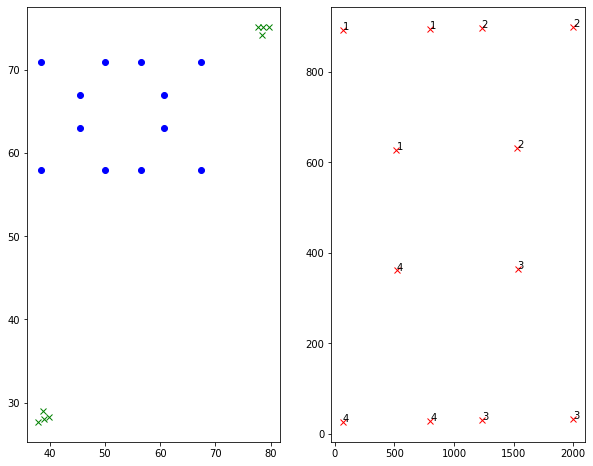

In [311]:
G = G8
plt.subplot(1,2,1)
plt.plot(G.mmx, G.mmy, 'bo');
plt.plot(gif_8_1.x, gif_8_1.y, 'gx')
plt.plot(gif_8_2.x, gif_8_2.y, 'gx')
plt.subplot(1,2,2)
plt.plot(G.mtnx, G.mtny, 'rx');
for x,y,q in zip(G.mtnx, G.mtny, G.quadrant):
    plt.text(x,y,'%i'%q)


In [289]:
for g in G4:
    print(g.img_fn, 'Q%i'%g.quadrant, g.orig_ssx, g.orig_ssy, '(%.1f, %.1f)' % (g.ssx, g.ssy))

IMG_30.fits Q0 2125.0 555.0 (0.0, 0.0)
IMG_31.fits Q3 1193.0 559.0 (1194.1, 559.2)
IMG_32.fits Q4 1029.0 559.0 (1028.8, 559.6)
IMG_33.fits Q4 129.0 562.0 (129.3, 562.5)
IMG_34.fits Q3 1660.0 890.0 (1661.2, 890.5)
IMG_35.fits Q4 580.0 894.0 (580.3, 894.5)
IMG_36.fits Q1 582.0 1209.0 (581.5, 1210.2)
IMG_37.fits Q2 1661.0 1205.0 (1662.4, 1206.2)
IMG_38.fits Q2 2129.0 1469.0 (2129.8, 1470.8)
IMG_39.fits Q2 1196.0 1473.0 (1197.6, 1474.6)
IMG_40.fits Q1 1033.0 1474.0 (1032.5, 1475.1)
IMG_41.fits Q1 133.0 1477.0 (132.9, 1478.0)


In [128]:
# Looking at prescan/overscan (avoiding headers that make ds9 ignore them:)
F = fitsio.FITS('/tmp/IMG_52.fits')
i1 = F[1].read()
i1.shape
fitsio.write('/tmp/521.fits', i1)